**Boilerplate.**

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# workshop folder, e.g. 'acmlab/workshops/project'
FOLDERNAME = 'acmlab/workshops/project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/acmlab/workshops/project


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from collections import defaultdict, namedtuple
import os

from PIL import Image

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(229)

import pandas as pd

import util
import webmercator
from tqdm import tqdm

**Predict function. Accepts a string file path to a .jpg image and outputs a prediction of the average income of the locale presented in the image.**

In [ ]:
def predict(filepath):
  image = Image.open(filepath).convert("RGB")
  convert = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
  tensor = convert(image)
  model = torch.load('/content/drive/My Drive/acmlab/workshops/project/KVK.pth')
  model.eval()
  with torch.no_grad():
    pred = model(image)
  return pred

**Part 1:** The first function you should write is `csv_to_data()`. This should take in a filename and returns a dictionary `data` from zipcode to average income.

In [ ]:
def csv_to_data(filename):
    """Takes in a `filename` and returns a dictionary `data` from zipcode to average income.
    For a given row, the average income is computed as row['A02650'] / row['N1']"""
    df = pd.read_csv(filename, usecols = ['ZIPCODE','A02650','N1'])
    data = {}
    for idx, row in df.iterrows():
      data[row[0]] = row[2] / row[1]
    return data

In [ ]:
data = csv_to_data('16zpallnoagi.csv')

**Part 2:** you should write the `load_zip_latlon_info` function. This function should:

- Take in a filename representing a path to a latitude/longitude data file with the following columns of interest:
    - `zip`: the zipcode
    - `state`: the state of the zipcode
    - `latitude`, `longitude`: the latitude and longitude of the zipcode
- Keep only zipcodes that are in our `data` dictionary.
- Convert the latitude and longitude to `x, y` values. (The `webmercator.xy(lat, lon, z)` function may be helpful here.)
- Create a dictionary from zipcode to `(x, y)` tuples.

In [ ]:
def load_zip_latlon_info(filename):
    """Takes in a `filename` and returns a dictionary from zipcode to (x, y)."""
    df = pd.read_csv(filename, sep=';')                     # the datafile is separated by semicolons for some reason
    df = df[df['state'] == 'CA']                            # will make your code more efficient to only work on CA
    zip_to_latlon = {}
    for idx, row in df.iterrows():                          # loop through the rows of the dataframe
        x, y = webmercator.xy(row[3], row[4], 14) # z is zoom, all images z=14
        if (2794 <= x <= 2839) and (6528 <= y <= 6572):     # only zip codes in the data set
             zip_to_latlon[row['zip']] = (x, y)             
    return zip_to_latlon

In [ ]:
zip_to_latlon = load_zip_latlon_info('ziplatlon.csv')
data = dict([kv for kv in data.items() if kv[0] in zip_to_latlon])        # data = dict([kv for kv in data.items() if kv[0] in zip_to_latlon])  
load_zip_latlon_info('ziplatlon.csv')

{90001: (2810.3666346666664, 6546.3783899610435),
 90002: (2810.3816533333334, 6547.728159016652),
 90003: (2809.1278222222218, 6546.938120419992),
 90004: (2807.6919466666664, 6540.656726296103),
 90005: (2807.6496213333335, 6541.656585653087),
 90006: (2808.294968888889, 6542.236657275279),
 90007: (2808.8137955555558, 6543.439581247661),
 90008: (2806.349368888889, 6544.356215777882),
 90009: (2808.096449422222, 6556.592244643842),
 90010: (2807.361536, 6541.447939950528),
 90011: (2809.9160746666666, 6544.503956398714),
 90012: (2810.7917084444452, 6541.508260285103),
 90013: (2810.6501688888893, 6542.439280798096),
 90014: (2810.223274666667, 6542.535398931322),
 90015: (2809.6211626666664, 6542.750641431188),
 90016: (2805.643946666667, 6543.260395304712),
 90017: (2809.6584817777784, 6542.005406321935),
 90018: (2807.202702222223, 6543.293289593617),
 90019: (2806.208284444445, 6542.233361617886),
 90020: (2807.6427946666663, 6541.241867046553),
 90021: (2810.6833920000004, 6543

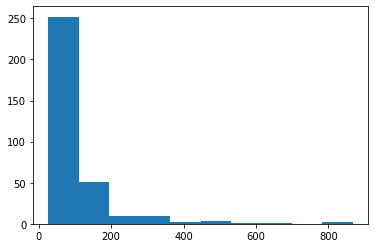

In [ ]:
plt.hist(list(d for d in data.values()))
plt.show()

**Part 3:** Write a function `euclidean_distance` that takes in two (x, y) tuples and returns the **squared** Euclidean distance between the two points.

In [ ]:
def euclidean_distance(pt1, pt2):
    return (pt2[1] - pt1[1]) ** 2 + (pt2[0] - pt1[0]) ** 2

**Part 4**: Write the dataset. The comments should be helpful in walking you through it.

For more understanding of how a dataset works, please consult the project handout.

Our implementation of the dataset takes about 6 minutes to finish running.  There are definitely more efficient ways to do it.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, main_dir, transform, data, zip_to_latlon):
        self.main_dir = main_dir
        self.transform = transform
        self.data = data
        self.zip_to_latlon = zip_to_latlon

        # Remove zip codes without labels
        zips = set(zip_to_latlon.keys()).intersection(set(self.data.keys()))
        self.zip_to_latlon = {k: zip_to_latlon[k] for k in zips}
        
        self.latlons = []
        self.total_imgs = []
        oceanic = 0

        # This loops through all the images in the directory.
        for filename in tqdm(sorted(os.listdir(main_dir))):             # tqdm lets you get a nice progress bar
            # Step 1: if the filename is not a .jpg, continue. 
            if not filename.endswith('.jpg'):
              continue
            # Step 2: extract the x and y values out of the filename.
            # Remember that a filename is of the form: 14_2817_6565.jpg 
            # where x=2817, y=6565.
            first = filename.find('_')
            end = filename.find('_', first + 1)
            (x, y) = (int(filename[first + 1:end]), int(filename[end + 1:len(filename) - 4]))
            # print(type(x), type(y))

            # Step 3: check if the tile is oceanic (i.e. has elevation 0).
            # The util.getElevation function takes in a **latitude** and **longitude** and returns an elevation.
            # To get a latitude and longitude from a x and y, use `webmercator.latlon(x, y, z=14)`.
            # If it is, ignore it.
            lati, longi = webmercator.latlon(x, y, 14) 
            if util.getElevation(lati, longi) <= 0:
              continue
            
            # Step 4: Append (x, y) to the self.latlons list.
            self.latlons.append((x, y))
            
            image = Image.open(os.path.join(main_dir,filename)).convert("RGB")
            self.total_imgs.append(image)
            
        self.zipcodes = []                                              # a list of zipcodes 
        self.tile_to_zipcode = {}
        # get the list of zip codes we need
        for zipcode, (zipcode_x, zipcode_y) in self.zip_to_latlon.items():   # loops through zipcodes and their x, y coordinates
            for x, y in self.latlons:                                   
                if self.in_tile((zipcode_x, zipcode_y), (x, y)):        # check if this zipcode is in the tile
                    self.zipcodes.append(zipcode)
                    self.tile_to_zipcode[(x, y)] = zipcode
        
        for idx, (x, y) in enumerate(self.latlons):
            if (x, y) not in self.tile_to_zipcode:                      # if this tile isn't already assigned
                # find the closest zipcode
                # you can use the `min(self.zipcodes, key=FUNCTION)` here

                best_zipcode = min(self.zipcodes, key=lambda zip: euclidean_distance((x, y), self.zip_to_latlon[zip]))           # fill this in
                self.tile_to_zipcode[(x, y)] = best_zipcode

        print(len(self.tile_to_zipcode), "entries.")
                
    def __len__(self):
        """Return the length of the dataset—how many images there are, total."""
        return len(self.total_imgs) # fill this in
    
    def coordinates(self, zipcode):
        """Returns the coordinates of the given zipcode."""
        return self.zip_to_latlon[zipcode]
    
    def in_tile(self, coord, square):
        """checks whether a given coordinate is in a tile"""
        lat, lon = coord
        llat, llon = square
        ulat, ulon = llat + 1, llon + 1
        return (lat >= llat and lon >= llon and lat <= ulat and lon <= ulon)
  
    def get_image(self, idx):
        """Returns the image at this index."""
        convert = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        return convert(self.total_imgs[idx])

    def get_label(self, idx):
        """Given an index, return the ground truth label for that index."""
        return self.data[self.tile_to_zipcode[self.latlons[idx]]]     # fill this in
    
    def __getitem__(self, idx):
        """Return the image and label at a given index"""
        tensor_image = self.get_image(idx) # fill this in
        label = self.get_label(idx) # fill this in
        return tensor_image, label
    
    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

In [ ]:
dset = ImageDataset('imagery', ToTensor(), data, zip_to_latlon)

100%|██████████| 1980/1980 [03:42<00:00,  8.91it/s]


1457 entries.


This code block creates train and validation dataloaders.

In [ ]:
validation_split = 0.10
dataset_size = len(dset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [ ]:
train_dataloader = DataLoader(dset, batch_size=250, sampler=train_sampler)
valid_dataloader = DataLoader(dset, batch_size=250, sampler=valid_sampler)
images, labels = iter(train_dataloader).next()

**Step 5**: Create the model.  Workshop 3 may be useful for this.
We suggest a series of convolutional layers interspersed with `torch.nn.MaxPool2d` layers, followed by a series of linear layers.
Each convolutional and linear layer should be followed by an activation function.

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 8, 3, 1, 1)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(8, 40, 3, 1, 1)
        self.conv3 = torch.nn.Conv2d(40, 160, 3, 1, 1)
        self.conv4 = torch.nn.Conv2d(160, 200, 3, 1, 1)
        self.fc1 = torch.nn.Linear(200 * 16 * 16, 1024)
        self.fc2 = torch.nn.Linear(1024, 256)
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc4 = torch.nn.Linear(64, 16)
        self.fc5 = torch.nn.Linear(16, 1)
        self.dropout = torch.nn.Dropout(0.5)


    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = self.pool(torch.nn.functional.relu(self.conv4(x)))
        x = x.view(-1, 200 * 16 * 16)
        x = torch.nn.functional.relu(self.fc1(self.dropout(x)))
        x = torch.nn.functional.relu(self.fc2(self.dropout(x)))
        x = torch.nn.functional.relu(self.fc3(self.dropout(x)))
        x = torch.nn.functional.relu(self.fc4(self.dropout(x)))
        x = self.fc5(self.dropout(x))
        return x.squeeze()

**Step 6**: Train the model. Use `torch.nn.MSELoss(reduction='sum')` here, or one of the other losses specified in the project spec, since we're trying to output a real value (not categories). 

In [ ]:
# train loop
model = Model().to('cuda:0')
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

writer = SummaryWriter()

num_epochs = 2500
for epoch_num in range(num_epochs):
    avg_train_loss = 0
    avg_train_l1 = 0
    for i, (img_batch, label) in enumerate(valid_dataloader):
        optimizer.zero_grad()
        img_batch = img_batch.cuda().to(dtype=torch.float32)
        label = label.cuda().to(dtype=torch.float32)
        
        # Step 1: feed your predictions into the model, outputting a variable `pred`
        pred = model(img_batch)
        # Step 2: calculate the loss w.r.t the predictions and the labels
        loss = criterion(pred, label)
        loss.backward()

        avg_train_loss += loss.detach()
        avg_train_l1 += torch.abs(pred - label).sum()
        torch.nn.utils.clip_grad_norm(model.parameters(), 10)
        optimizer.step()

    avg_train_loss /= len(train_indices)
    avg_train_l1 /= len(train_indices)

    with torch.no_grad():
        model.eval()
        avg_val_loss = 0
        avg_val_l1 = 0
        for i, (img_batch, label) in enumerate(valid_dataloader):
            img_batch = img_batch.cuda()
            label = label.cuda()

            # Step 1: feed your predictions into the model, outputting a variable `pred`
            pred = model(img_batch)
            # Step 2: calculate the loss w.r.t the predictions and the labels
            loss = criterion(pred, label)

            avg_val_loss += loss
            avg_val_l1 += torch.abs(pred - label).sum()
        avg_val_loss /= len(val_indices)
        avg_val_l1 /= len(val_indices)
    if epoch_num % 25 == 0 or epoch_num == num_epochs - 1:    
      print(epoch_num, float(avg_train_loss), float(avg_val_loss), float(avg_train_l1), float(avg_val_l1))
torch.save(model, '/content/drive/My Drive/acmlab/workshops/project/KVK.pth')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


0 2188.367431640625 19797.706621288835 11.316014289855957 102.37255314246387
25 1736.5216064453125 15138.392793169161 8.704666137695312 74.90169689402741
50 1143.717529296875 10343.728786542184 6.191953659057617 54.1802273930889
75 1100.1192626953125 9936.971075468415 6.012655735015869 54.68587078588651
100 1009.8765869140625 9099.8605370801 5.506010055541992 49.756828897339325
125 968.6456298828125 8753.146171259481 5.554342269897461 50.1277192811373
150 933.325439453125 8428.147961123304 5.548573017120361 50.20761033978835
175 855.6986083984375 7698.598337393938 5.5031938552856445 49.826398803486946
200 653.5201416015625 5803.7320617703845 5.193674564361572 46.828762448561
225 353.6094665527344 3098.5704070265388 4.339542388916016 39.09203287696875
250 192.6604766845703 1738.8895284212072 3.589629888534546 32.64143867618078
275 128.22055053710938 1128.0011487094434 2.7181053161621094 24.39646189801106
300 95.1417236328125 807.397710180292 2.3865623474121094 21.293916454479042
325 78.

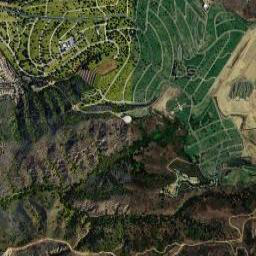

Actual: 63.400718015665795
Predicted: 213.29444885253906


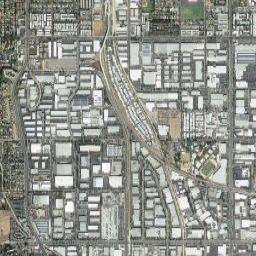

Actual: 91.29127155172414
Predicted: 51.94290542602539


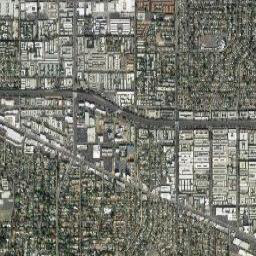

Actual: 123.99522807017544
Predicted: 88.6407470703125


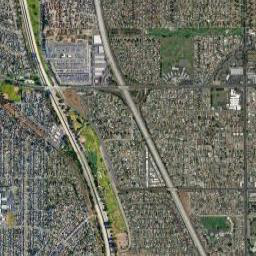

Actual: 74.71770538243626
Predicted: 76.96658325195312


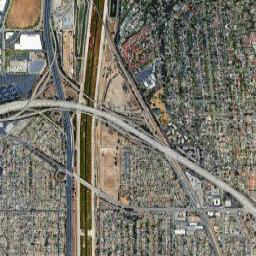

Actual: 41.89093064611737
Predicted: 163.258056640625


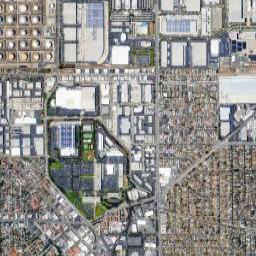

Actual: 66.18976799524093
Predicted: 55.611244201660156


In [ ]:
for i in [700, 3, 52, 611, 458, 299]: #try making a plot of loss over epochs
    display(dset.total_imgs[i])
    print("Actual:", dset[i][1])
    print("Predicted:", model(dset[i][0].unsqueeze(0).cuda()).item())